# Linear regression

## Problem
Build a model and predict pricing of the apartment rent in Graz based on data in the ad

## Goals

- Manually write linear regression algorithm
    - Gradient descent function
    - Cost function implementation
    - Normal equation function
    - Feature enumeration and normalization function
- Use libraries and compare it with manual result

## Data description

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Area | Objective Feature | area | float (square meters) |
| Rooms number | Objective Feature | rooms | string  |
| Zip code | Objective Feature | zip | string |
| District | Objective Feature | district | string |
| Is the ad private| Objective Feature | is_private | boolean |
| Is the flat in the city center | Objective Feature | center | boolean |
| Pricing of the ad | Target Variable | price | float |

## Read data from pickle

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import maplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 16})

df = pd.read_pickle('apartmetns.pkl')

ModuleNotFoundError: No module named 'maplotlib'

## Data selection

In [6]:
# We will make a copy of the dataset
X = df.loc[:, ~df.columns.isin(['price', 'advertiser', 'link-href', 'is_private', 'zip', 'district'])]
y = df['price']

In [7]:
X

,area,rooms,center
1,100.0,3,False
2,90.0,3,False
3,21.0,1,True
4,50.0,2,False
5,103.0,3,False
...,...,...,...
3672,53.0,3,False
3673,60.0,3,False
3674,67.0,3,False
3675,105.0,3,True


In [8]:
y.head()

1    996.78
2    700.00
3    322.07
4    671.00
5    749.00
Name: price, dtype: float64

## Categorical features enumeration

In [9]:
def cats_to_codes(df, feature, ordered=None):
    return dict(df[feature].value_counts().astype('category').cat.codes)

In [10]:
def codes_to_cats(feature, code_dict):
    return {value:key for key, value in code_dict.items()}

zip_codes = cats_to_codes(X, 'zip')
X.zip = X.zip.map(zip_codes)

In [11]:
X.head()

,area,rooms,center
1,100.0,3,False
2,90.0,3,False
3,21.0,1,True
4,50.0,2,False
5,103.0,3,False


In [12]:
rooms_codes = cats_to_codes(X, 'rooms')
X.rooms = X.rooms.map(rooms_codes)

/opt/miniconda3/envs/mlenv/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
X.head()

,area,rooms,center
1,100.0,2,False
2,90.0,2,False
3,21.0,1,True
4,50.0,3,False
5,103.0,2,False


district_codes = cats_to_codes(X, 'district')
X.district = X.district.map(district_codes)

In [14]:
#X.is_private = X.is_private.astype('int')
X.center = X.center.astype('int')

/opt/miniconda3/envs/mlenv/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
X

,area,rooms,center
1,100.0,2,0
2,90.0,2,0
3,21.0,1,1
4,50.0,3,0
5,103.0,2,0
...,...,...,...
3672,53.0,2,0
3673,60.0,2,0
3674,67.0,2,0
3675,105.0,2,1


## Feature normalization

In [17]:
import numpy as np

mean_X = np.mean(X)
std_X = np.std(X)

In [18]:
def normalize(x, mean, std):
    return (x - mean)/std

In [19]:
for feat in X.columns:
    X[feat] = (X[feat] - mean_X[feat])/std_X[feat]

<ipython-input-19-3033a60703a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = (X[feat] - mean_X[feat])/std_X[feat]


In [20]:
X

,area,rooms,center
1,1.918100,-0.281292,-0.740279
2,1.443325,-0.281292,-0.740279
3,-1.832624,-1.399363,1.350843
4,-0.455776,0.836779,-0.740279
5,2.060533,-0.281292,-0.740279
...,...,...,...
3672,-0.313343,-0.281292,-0.740279
3673,0.018999,-0.281292,-0.740279
3674,0.351342,-0.281292,-0.740279
3675,2.155488,-0.281292,1.350843


## First hyphotesis
$$
h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + 
\theta_4 x_4 + \theta_5 x_5 + \theta_6 x_6  
$$

### Adding of intercept term x0

In [21]:
X.insert(loc=0, column='x0', value=np.ones(len(X)))

In [22]:
X

,x0,area,rooms,center
1,1.0,1.918100,-0.281292,-0.740279
2,1.0,1.443325,-0.281292,-0.740279
3,1.0,-1.832624,-1.399363,1.350843
4,1.0,-0.455776,0.836779,-0.740279
5,1.0,2.060533,-0.281292,-0.740279
...,...,...,...,...
3672,1.0,-0.313343,-0.281292,-0.740279
3673,1.0,0.018999,-0.281292,-0.740279
3674,1.0,0.351342,-0.281292,-0.740279
3675,1.0,2.155488,-0.281292,1.350843


### Conversion of X and y to numpy arrays 

In [23]:
X = X.to_numpy()
y = y.to_numpy().reshape((-1, 1))

In [24]:
X.shape, y.shape

((3466, 4), (3466, 1))

In [25]:
def computeCost(X, y, theta):
    m = len(y) 
    J = 1/(2*m) * np.sum(np.power(np.subtract(X.dot(theta), y), 2))
    return J

In [26]:
theta = np.zeros((X.shape[1], 1))

In [27]:
theta.shape

(4, 1)

In [28]:
computeCost(X, y, theta)

263974.43644081074

In [29]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = np.zeros((num_iters, 1))
    for i in range(num_iters):
        error = X.dot(theta) - y
        theta = theta - (alpha/m) * X.T.dot(error)
        J_history[i] = computeCost(X, y, theta)
    return theta, J_history

In [30]:
new_theta, J_history = gradientDescent(X, y, theta, 0.1, 100)

In [31]:
computeCost(X, y, new_theta)

5609.476648950775

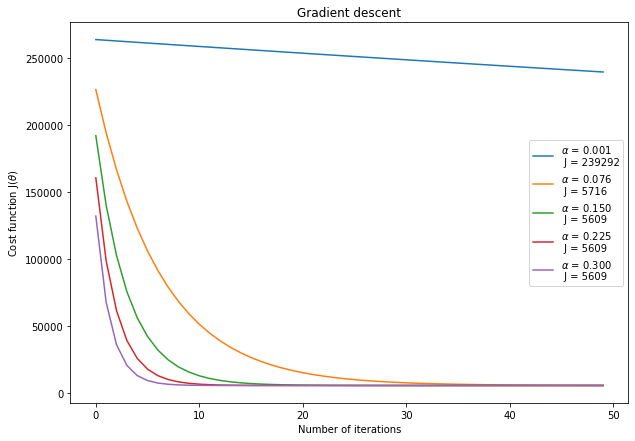

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7));

alphas = np.linspace(0.001, 0.3, 5)
for a in alphas:
    _, J_history = gradientDescent(X, y, theta, a, 50)
    plt.plot(np.arange(J_history.shape[0]), J_history, label=(r'$\alpha$ = {:1.3f}'.format(a) \
                                                              + '\n J = {}'.format(int(J_history[-1][0]))))

plt.legend()
plt.xlabel('Number of iterations');
plt.ylabel(r'Cost function J($\theta$)')
plt.title("Gradient descent");

### Quick test for hyphothesis

In [ ]:
new_theta, J_history = gradientDescent(X, y, theta, 0.1, 100)

In [ ]:
new_theta

In [ ]:
mean_X, std_X

In [ ]:
f = [44, 1, 1]
x = []

for i in range(mean_X.shape[0]):
    x.append(normalize(f[i], mean_X[i], std_X[i]))

In [ ]:
x = [1,] + x

In [ ]:
x = np.array(x)

In [ ]:
new_theta.T.dot(x)

Looks valid

## Model validation

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
def predict(X, theta):
    return X.dot(theta)

In [ ]:
theta

In [ ]:
new_theta, _ = gradientDescent(train_X, train_y, theta, 0.1, 100)

In [ ]:
val_predictions = predict(val_X, new_theta)

In [ ]:
print(val_predictions[:10])

In [ ]:
print(val_y[:10])

### Calculation of the Mean Absolute Error in Validation Data

In [ ]:
from sklearn.metrics import mean_absolute_error
val_mae = mean_absolute_error(val_y, val_predictions)

In [ ]:
val_mae

## Normal equation

$$
\theta = (X^T X)^{-1}X^T \bar{y}
$$

In [ ]:
def normalEqn(X, y):
    m = len(y)
    theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [ ]:
norm_theta = normalEqn(X, y)

Should be more accurate

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
val_predictions = predict(val_X, norm_theta)

In [ ]:
val_mae = mean_absolute_error(val_y, val_predictions)
val_mae

## Predicting prices usign scikit linear regressor

In [ ]:
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression(fit_intercept=False, n_jobs=-1)
regressor.fit(X_train, y_train)

In [ ]:
print('Weight coefficients: ', regressor.coef_)

In [ ]:
y_pred_train = regressor.predict(X_test)

In [ ]:
y_pred_train[0:10]

In [ ]:
val_mae = mean_absolute_error(y_test, y_pred_train)
val_mae